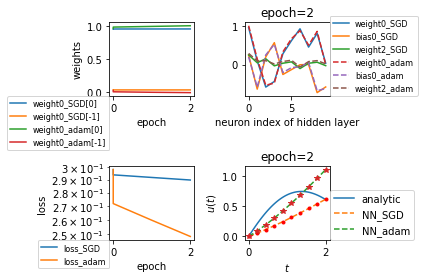

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#否则内核时常挂掉
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import copy# copy NN
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

###################### hyperparameters ######################
neurons=10# neurons in hidden layer
batchsize = 10 # how many points to use per epoch
epochs = 3 # number of epochs
learnrate = 0.01

###################### ODE ######################
uo=0
f = lambda t, u: torch.exp(-t/ 5.0) * torch.cos(t) - u/ 5.0
U = lambda t, NN: uo + t * NN(t)

def loss(t,U):
    t.requires_grad = True
    Uot= U(t)
    dudt=torch.autograd.grad(Uot,t,grad_outputs=torch.ones_like(Uot),create_graph=True)[0]
    return torch.mean((dudt-f(t,Uot))**2)

tspan = np.linspace(0, 2, 100)[:, None]
t = torch.linspace(0, 2, batchsize).reshape(-1,1)
uA = np.exp(-tspan/ 5.0) * np.sin(tspan)# analytic


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

############### init ###############
NN_SGD = nn.Sequential(nn.Linear(1,neurons), nn.Sigmoid(), nn.Linear(neurons,1, bias=False))
sgd = torch.optim.SGD(NN_SGD.parameters(), lr=learnrate)
weight0_SGD = list(NN_SGD[0].parameters())[0];weight0_SGD = weight0_SGD.detach().numpy();
bias0_SGD = list(NN_SGD[0].parameters())[1];bias0_SGD = bias0_SGD.detach().numpy();
weight2_SGD = list(NN_SGD[2].parameters())[0];weight2_SGD = weight2_SGD.detach().numpy();
epoch_SGD = []; w1_SGD = []; w2_SGD = []; loss_SGD = [];

NN_adam = copy.deepcopy(NN_SGD)
adam = torch.optim.Adam(NN_adam.parameters(), lr=learnrate)
weight0_adam = list(NN_adam[0].parameters())[0];weight0_adam = weight0_adam.detach().numpy();
bias0_adam = list(NN_adam[0].parameters())[1];bias0_adam = bias0_adam.detach().numpy();
weight2_adam = list(NN_adam[2].parameters())[0];weight2_adam = weight2_adam.detach().numpy();
epoch_adam = []; w1_adam = []; w2_adam = []; loss_adam = [];

############### train ###############
def animate(epoch):
    sgd.zero_grad()
    l_SGD = loss(t,NN_SGD)
    l_SGD.backward()
    sgd.step()# torch's step
    epoch_SGD.append(epoch)
    w1_SGD.append(float(weight0_SGD[0]))
    w2_SGD.append(float(weight0_SGD[-1]))
    loss_SGD.append(float(l_SGD))
    uNN_SGD = U(torch.Tensor(tspan), NN_SGD).detach().numpy()
    
    adam.zero_grad()
    l_adam = loss(t,NN_adam)
    l_adam.backward()
    adam.step()# torch's step
    epoch_adam.append(epoch)
    w1_adam.append(float(weight0_adam[0]))
    w2_adam.append(float(weight0_adam[-1]))
    loss_adam.append(float(l_adam))
    uNN_adam = U(torch.Tensor(tspan),NN_adam).detach().numpy()

    
    ax1.clear()# hold off
    line1,=ax1.plot(epoch_SGD,w1_SGD,label="weight0_SGD[0]");
    line1,=ax1.plot(epoch_SGD,w2_SGD,label="weight0_SGD[-1]");
    line1,=ax1.plot(epoch_adam,w1_adam,label="weight0_adam[0]");
    line1,=ax1.plot(epoch_adam,w2_adam,label="weight0_adam[-1]");
#    ax1.legend(loc='lower right', markerscale=0.1,  bbox_to_anchor=(1,1));
    ax1.legend(bbox_to_anchor=(0, 0), loc=0, borderaxespad=0, prop={'size': 8})
    ax1.set_xlabel('epoch');ax1.set_ylabel('weights')

    ax2.clear()# hold off
#    x = np.arange(neurons)
    line2,=ax2.plot(weight0_SGD,label='weight0_SGD');
    ax2.plot(bias0_SGD,label='bias0_SGD');
    ax2.plot(weight2_SGD.T,label='weight2_SGD');
    
    ax2.plot(weight0_adam,'--', label='weight0_adam');
    ax2.plot(bias0_adam,'--', label='bias0_adam');
    ax2.plot(weight2_adam.T,'--', label='weight2_adam');
    ax2.set_title(f"epoch={epoch}");ax2.set_xlabel('neuron index of hidden layer');
    ax2.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0, prop={'size': 8})# ax2.legend(loc='best')
#    ax2.legend(loc='lower right', markerscale=0.1,  bbox_to_anchor=(1,1));

    ax3.clear()# hold off
    line3, = ax3.semilogy(epoch_SGD, loss_SGD, label='loss_SGD')
    ax3.semilogy(epoch_adam, loss_adam, label='loss_adam')
    ax3.set_xlabel('epoch');ax3.set_ylabel('loss');
    ax3.legend(bbox_to_anchor=(0, 0), loc=0, borderaxespad=0, prop={'size': 8})
#    ax3.legend(loc='best', markerscale=0.1,  bbox_to_anchor=(1,1)); 

    ax4.clear()# hold off
    ax4.set_title(f"epoch={epoch}");ax4.set_xlabel('$t$');ax4.set_ylabel('$u(t)$');
    line4,=ax4.plot(tspan,uA,label='analytic');ax4.plot(tspan,uNN_SGD,'--',label='NN_SGD');
    ax4.plot(tspan,uNN_adam,'--',label='NN_adam');
    ax4.plot(t.detach().numpy(),U(torch.Tensor(t),NN_SGD).detach().numpy(), 'r.');
    ax4.plot(t.detach().numpy(),U(torch.Tensor(t),NN_adam).detach().numpy(), '*');
    ax4.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
#    ax4.legend(loc='best', markerscale=0.1,  bbox_to_anchor=(1,1));
    
    plt.tight_layout()#否则图部分遮住
    return line1,line2,line3,line4
    

import matplotlib.animation as animation
ani = animation.FuncAnimation(fig, animate, frames = epochs, interval=200, repeat=False, blit=True)
# ani.save('animation.gif',writer='ffmpeg',fps=1000)
from IPython.display import HTML
HTML(ani.to_jshtml()) # javascript-HTML Embed animation